In [1]:
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import clear_output

#### Reading Data Functions

In [2]:
def read_params_data(folder_path):
    file_path = folder_path + 'params.json'
    with open(file_path) as readFile:
        return json.load(readFile)

In [3]:
def read_agents_data(folder_path, num_agents):
    agents_data = {}
    for ant in range(1, num_agents+1):
        agents_data[ant] = pd.read_pickle(folder_path + 'agent_' + str(ant) + '.pkl')    
    return agents_data

#### Binning Data Functions

In [4]:
def generate_chunks(seq, size):
    for pos in range(0, len(seq), size):
        yield seq.iloc[pos:pos+size]

In [5]:
def create_binned_actions(agent_df, actions, bin_size, num_bins):
    actions_df = agent_df.filter(['action'])

    binned_actions = {}
    for i in actions:
        binned_actions[i] = []
    
    for chunk in generate_chunks(actions_df, bin_size):
        action_count = chunk['action'].value_counts()
    
        for action in actions:
            try:
                binned_actions[action].append(action_count[action])
            except:
                binned_actions[action].append(0)
    
    for action in actions:
        binned_actions[i] = np.array(binned_actions[i])
    
    return binned_actions

In [6]:
def create_binned_trips(agent_df, bin_size, num_bins):
    trips_df = agent_df.filter(['tripCompleted'])
    
    binned_trips = []

    for chunk in generate_chunks(trips_df, bin_size):
        trips_count = chunk['tripCompleted'].value_counts()
    
        try:
            binned_trips.append(trips_count[1])
        except:
            binned_trips.append(0)
    
    return np.array(binned_trips)

#### Plotting Data Functions

In [7]:
def create_plot(binned_actions, binned_trips, actions, agent):
    fig, axes = plt.subplots(2, 1, figsize = (10,10))

    x = np.array(range( len(binned_trips) )) * bin_size
    y_actions = []
    for action in actions:
        y_actions.append( binned_actions[action] )

    axes[0].stackplot(x, y_actions, labels = action_legends)
    axes[0].title.set_text('Actions of agent '+str(agent))
    axes[0].legend(loc='upper left')

    y_trips = binned_trips
    
    axes[1].plot(x, y_trips, label ='Successful trips per agent for ' +str(bin_size)+ ' time steps')
    axes[1].title.set_text('Successful trips of agent '+str(agent))
    axes[1].legend(loc='upper left')
    
    fig.tight_layout()
    fig.savefig(root + folder + '/' +folder+ '_agent_' + str(agent) + '.jpg', bbox_inches='tight', dpi=250)
    # fig.savefig(root + folder + '_graphs/agent_' + str(agent) + '.jpg', bbox_inches='tight', dpi=250)

## Main

- Create every list as numpy arrays - predefine the size of binned values and only replace them
- Write x-values as 10k, 100k
- Put legends on the right end

In [8]:
action_legends = [
    'Drop Home Pheromone', 
    'Drop Food Pheromone', 
    'Follow Home Pheromone', 
    'Follow Food Pheromone',
    'Move Randomly'
]

In [9]:
root = '../data/'
folders = os.listdir(root)
folder = folders[-1]
folder_path = root + folder + '/'

In [10]:
# os.mkdir(root+folder+'_graphs')

In [11]:
simulation_data = {}
simulation_data['params'] = read_params_data(folder_path)

In [12]:
bin_size = 5000
antCount = simulation_data['params']['antCount']
actions = simulation_data['params']['actions']
stepsCount = simulation_data['params']['stepsCount']
num_bins = math.ceil(stepsCount / bin_size)

#### Read Data

In [13]:
simulation_data['agents'] = read_agents_data(folder_path, antCount)

#### Bin Data

In [14]:
simulation_data['binned_actions'] = {}
simulation_data['binned_trips'] = {}
simulation_data['binned_epsilon'] = {}

for ant in range(1, antCount+1):
    simulation_data['binned_actions'][ant] = create_binned_actions(simulation_data['agents'][ant], actions, bin_size, num_bins)
    simulation_data['binned_trips'][ant] = create_binned_trips(simulation_data['agents'][ant], bin_size, num_bins)

In [15]:
simulation_data['total_binned_actions'] = {}

for action in actions:
    simulation_data['total_binned_actions'][action] = np.zeros(num_bins)

simulation_data['total_binned_trips'] = np.zeros(num_bins)

In [16]:
for ant in range(1, antCount+1):
    for action in actions:
        simulation_data['total_binned_actions'][action] += simulation_data['binned_actions'][ant][action]
        simulation_data['total_binned_trips'] += simulation_data['binned_trips'][ant]

#### Plot Data

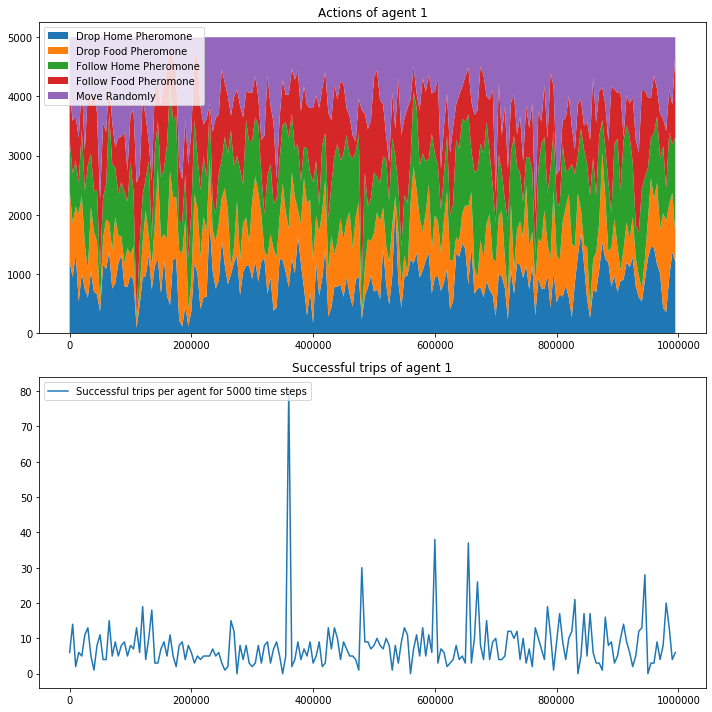

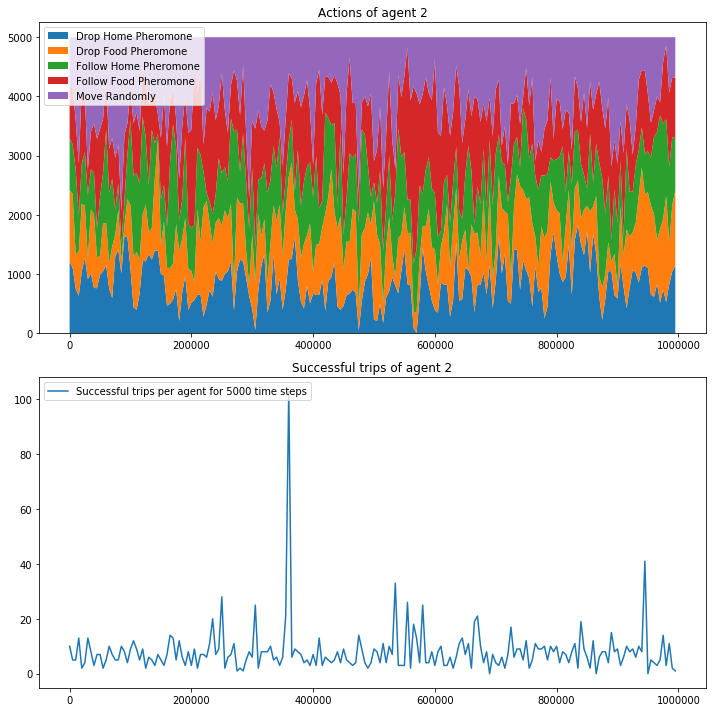

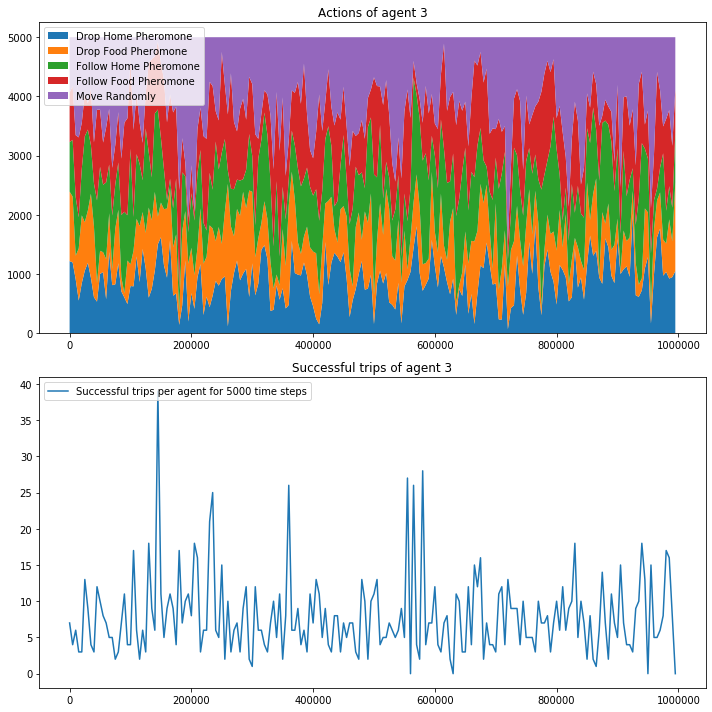

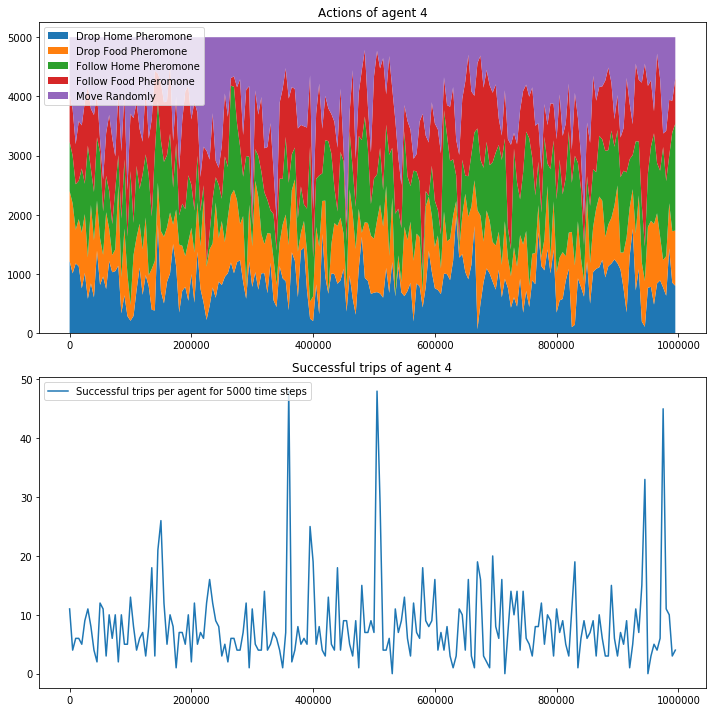

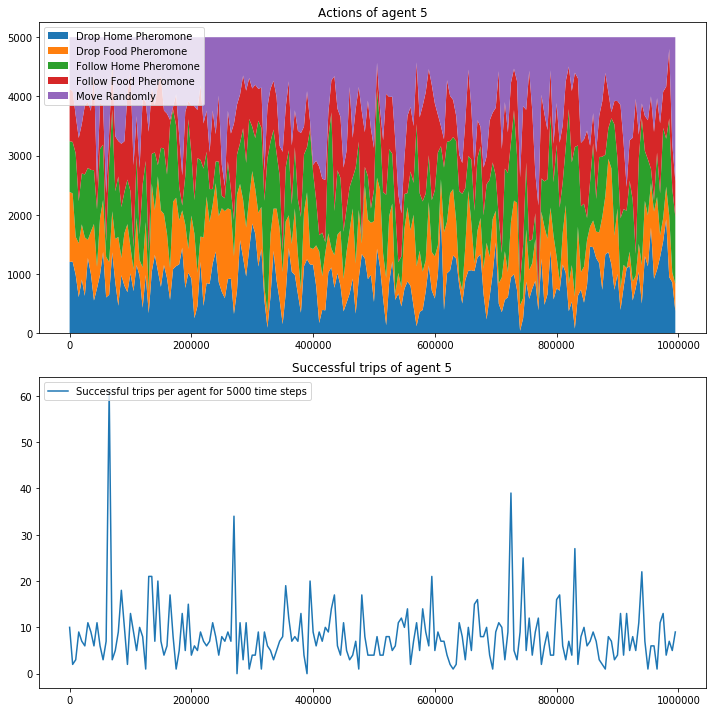

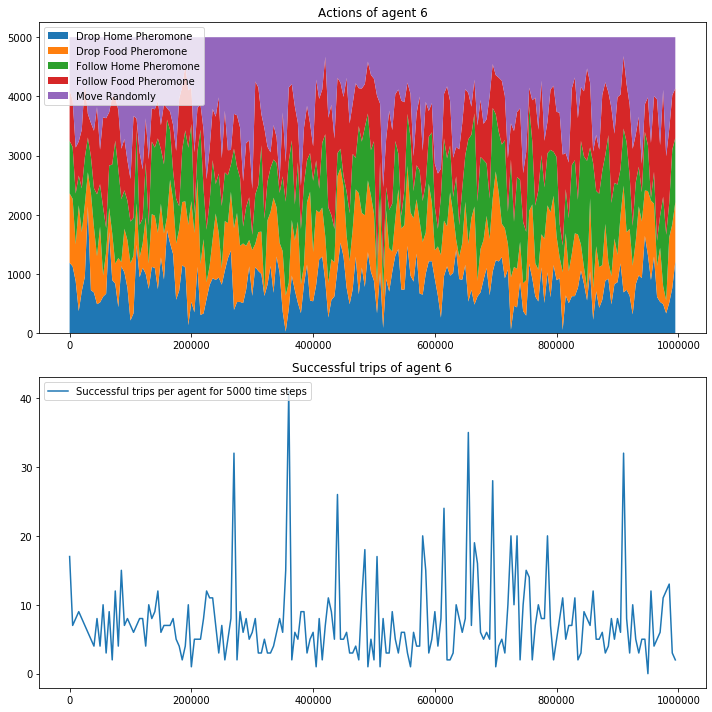

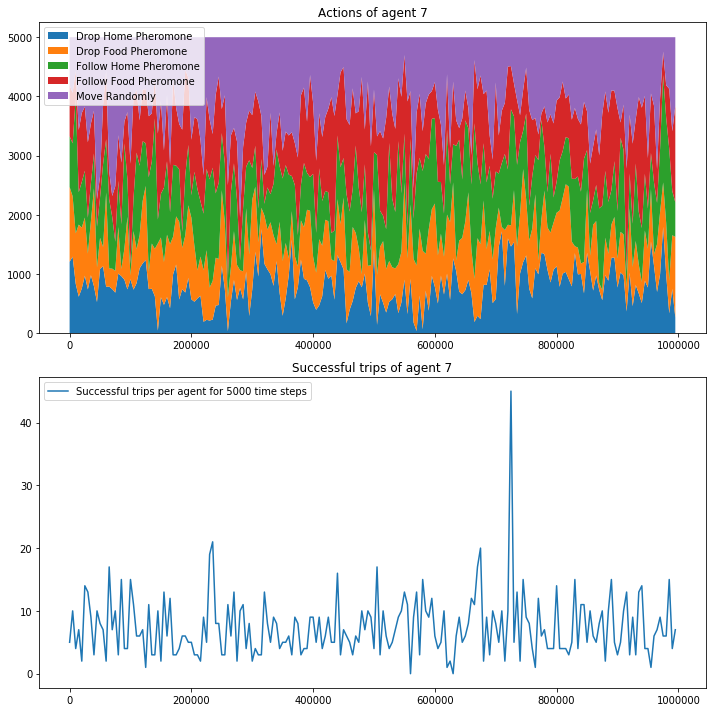

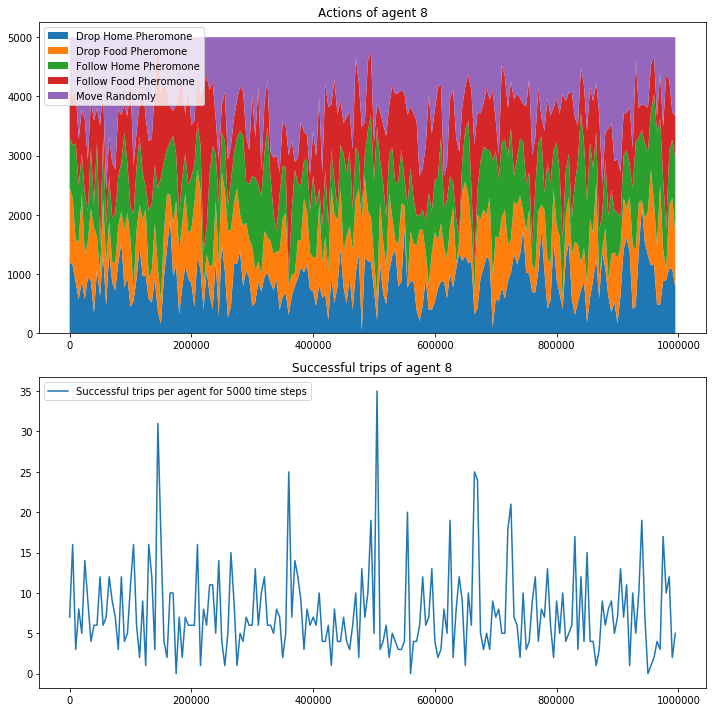

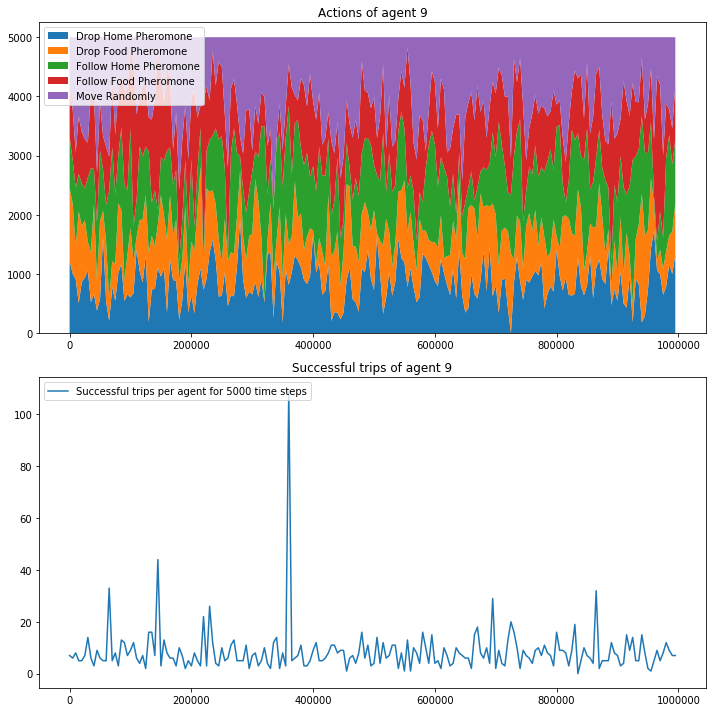

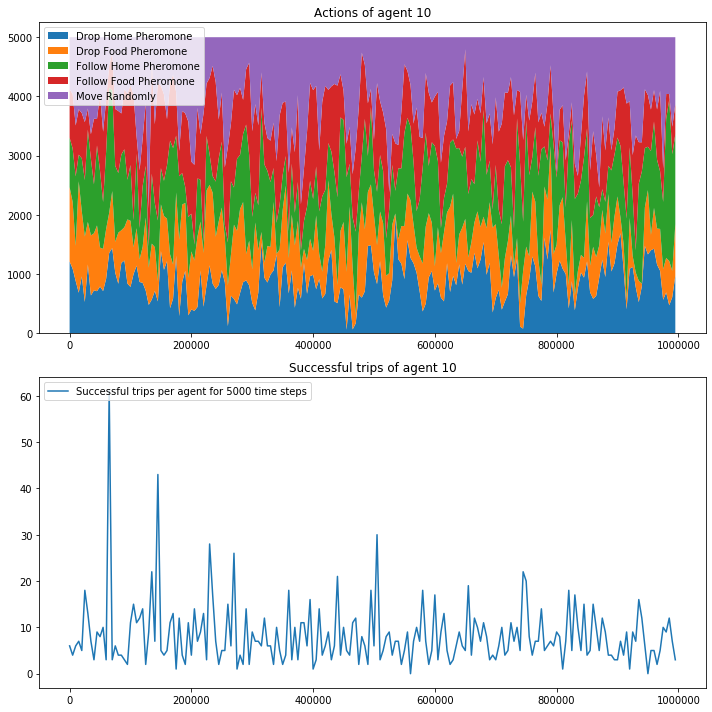

In [17]:
for ant in range(1, antCount+1):
    create_plot(
        simulation_data['binned_actions'][ant], 
        simulation_data['binned_trips'][ant], 
        actions, 
        ant
    )

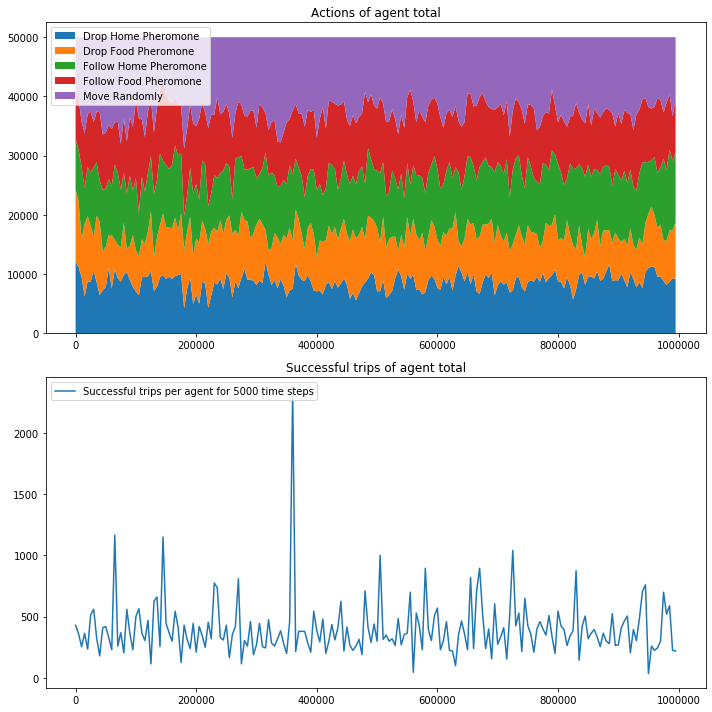

In [18]:
create_plot(
    simulation_data['total_binned_actions'], 
    simulation_data['total_binned_trips'], 
#     simulation_data['total_binned_epsilon'], 
    actions, 
    'total'
)

#### Debugging

In [19]:
a = np.zeros([2,3])
a+1

array([[1., 1., 1.],
       [1., 1., 1.]])